# Active Learning with ConvNP Model

In this notebook, we implement **active learning** to improve model training by selecting the most informative data points for the model to focus on. Specifically, we:
1. Preprocess the dataset and define helper functions for data normalization.
2. Use a **Greedy Algorithm** for active learning to iteratively sample the most uncertain data points.
3. Implement **Standard Deviation Acquisition Function** to guide the model to focus on uncertain regions in the data.
4. Visualize the placement of new data points selected by active learning.

Let’s begin by importing necessary packages and defining helper functions.


## Step 1: Import Packages and Define Helper Functions

We import the libraries required for:
- Data manipulation and visualization (`xarray`, `pandas`, `matplotlib`).
- Geospatial operations (`cartopy`).
- Active learning (`deepsensor`).
- PyTorch for model training and inference.

We also define helper functions like `standardize_dates` for normalizing the 'time' dimension to date-only precision and `generate_random_coordinates` to sample random coordinates from the lake mask.


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask.array as da
import os

import json
import torch  

import torch
import deepsensor.torch
from deepsensor.data import DataProcessor, TaskLoader, construct_circ_time_ds
from deepsensor.model.nps import construct_neural_process
from deepsensor.model import ConvNP
from deepsensor.train import Trainer, set_gpu_default_device

In [2]:
set_gpu_default_device()

In [3]:
def standardize_dates(ds):
    """
    Convert the 'time' dimension in an xarray dataset to date-only precision with datetime64[D].
    
    Parameters:
    ds (xarray.Dataset): The dataset whose 'time' dimension you wish to modify.
    
    Returns:
    xarray.Dataset: Modified dataset with time as datetime64[D].
    """
    if 'time' in ds.coords:
        # Convert time to day-level precision
        ds['time'] = ds['time'].dt.floor('D').values.astype('datetime64[D]')
    
    return ds

In [4]:
def generate_random_coordinates(mask_da, N, data_processor=None):
    """
    Generate N random coordinates (lat, lon) from a mask with values 1 inside the lake area,
    and normalize them using the DataProcessor if provided.
    
    Parameters:
    mask_da: xarray DataArray containing the mask (with 1 for valid, 0 for invalid areas)
    N: Number of random points to generate
    data_processor: (optional) DataProcessor object for normalization if needed
    
    Returns:
    numpy.ndarray: Array of shape (2, N) with random latitudes and longitudes from the masked region
    """
    
    # Get the valid indices where the mask is 1
    mask = mask_da['mask'].values
    valid_indices = np.argwhere(mask == 1)
    
    # Randomly sample N points from the valid indices
    random_indices = valid_indices[np.random.choice(valid_indices.shape[0], N, replace=False)]
    
    # Get the latitude and longitude coordinates for the sampled indices
    latitudes = mask_da['lat'].values[random_indices[:, 0]]
    longitudes = mask_da['lon'].values[random_indices[:, 1]]
    
    # Create a dummy variable (e.g., zeros for now)
    dummy_variable = np.random.rand(N)
    
    # Create a Pandas DataFrame with latitudes, longitudes, and the dummy variable
    random_coords_df = pd.DataFrame({
        'lat': latitudes,
        'lon': longitudes,
        'dummy': dummy_variable
    })
    
    # Set the index to ['lat', 'lon'] to match what DataProcessor expects
    random_coords_df = random_coords_df.set_index(['lat', 'lon'])
    
    if data_processor:
        normalized_coords_df = data_processor(random_coords_df, method="min_max")
        return normalized_coords_df.index.to_frame(index=False).values.T
    else:
        return np.vstack((latitudes, longitudes))


In [5]:
import os
import json
import torch
import numpy as np
import re

from deepsensor.model import ConvNP
from deepsensor.model.nps import construct_neural_process
from deepsensor.data import DataProcessor, TaskLoader

# --- Your custom save function (copy this exactly) ---
def save_model(model, model_ID: str):
    os.makedirs(model_ID, exist_ok=True)
    torch.save(model.model.state_dict(), os.path.join(model_ID, "model.pt"))
    config_fpath = os.path.join(model_ID, "model_config.json")
    with open(config_fpath, "w") as f:
        json.dump(model.config, f, indent=4, sort_keys=False, default=str)

# --- Helper functions for deserialization (copy these exactly) ---
def _convert_string_to_numeric_if_possible(value):
    if isinstance(value, str):
        if re.fullmatch(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", value):
            try:
                return float(value)
            except ValueError:
                pass
    return value

def _deserialize_config(config_data):
    if isinstance(config_data, dict):
        deserialized = {}
        for key, value in config_data.items():
            deserialized[key] = _deserialize_config(value)
        return deserialized
    elif isinstance(config_data, list):
        return [_deserialize_config(item) for item in config_data]
    else:
        converted_val = _convert_string_to_numeric_if_possible(config_data)
        if isinstance(converted_val, str):
            import torch.nn as nn
            if converted_val == "<class 'torch.nn.modules.activation.ReLU'>":
                return nn.ReLU
            elif converted_val == "<class 'torch.nn.modules.activation.LeakyReLU'>":
                return nn.LeakyReLU
            else:
                return converted_val
        else:
            return converted_val

# --- Your main custom load function (FULLY REVISED AGAIN) ---
def load_convnp_model(model_ID: str, data_processor: DataProcessor, task_loader: TaskLoader):
    config_fpath = os.path.join(model_ID, "model_config.json")
    with open(config_fpath, "r") as f:
        config_raw = json.load(f)

    deserialized_config = _deserialize_config(config_raw)

    # Prepare config for constructing the underlying neural process.
    # This config should ONLY contain architectural parameters for construct_neural_process.
    config_for_nps_constructor = deserialized_config.copy()

    # Remove the keys that are only for internal DeepSensorModel tracking,
    # or are to be passed separately as positional arguments to ConvNP.
    if 'family' in config_for_nps_constructor:
        del config_for_nps_constructor['family']
    if 'neural_process_type' in config_for_nps_constructor:
        del config_for_nps_constructor['neural_process_type']
    # Ensure data_processor and task_loader are NOT in this dict, as they will be passed positionally
    if 'data_processor' in config_for_nps_constructor: # Defensive check, should not be there from JSON
        del config_for_nps_constructor['data_processor']
    if 'task_loader' in config_for_nps_constructor: # Defensive check
        del config_for_nps_constructor['task_loader']


    print("Attempting to instantiate ConvNP model (randomly initialized initially):")
    print("Architectural config for construct_neural_process (passed as **kwargs):", config_for_nps_constructor)

    try:
        # Instantiate ConvNP.
        # In DeepSensor 0.4.2, ConvNP's __init__ expects data_processor and task_loader
        # as its first two positional arguments, and then forwards remaining kwargs
        # to construct_neural_process.
        loaded_convnp_model = ConvNP(
            data_processor, # Positional argument 1 for DeepSensorModel super().__init__
            task_loader,    # Positional argument 2 for DeepSensorModel super().__init__
            **config_for_nps_constructor # Remaining architectural kwargs for construct_neural_process
        )
    except Exception as e:
        print(f"Error when instantiating ConvNP: {e}")
        # Print the *full context* for debugging, including positional arguments
        debug_info = {
            'data_processor_arg': data_processor,
            'task_loader_arg': task_loader,
            'architectural_kwargs': config_for_nps_constructor
        }
        import pprint
        pprint.pprint(debug_info)
        raise

    # Now, load the actual trained weights into the 'model' attribute of the
    # randomly initialized ConvNP instance. This overrides the random weights.
    model_weights_fpath = os.path.join(model_ID, "model.pt")
    loaded_convnp_model.model.load_state_dict(
        torch.load(model_weights_fpath, map_location='cuda' if torch.cuda.is_available() else 'cpu', weights_only=True)
    )
    # Ensure the model is on the correct device
    loaded_convnp_model.model.to('cuda' if torch.cuda.is_available() else 'cpu')


    # Update the 'config' attribute of the ConvNP model instance
    # with the *full* deserialized config (including 'family' and 'neural_process_type'),
    # as this is how it was originally saved and expected by the ConvNP object itself.
    loaded_convnp_model.config = deserialized_config

    return loaded_convnp_model

## Step 2: Data Inventory and Preprocessing

In this section, we load and preprocess the required datasets for active learning:
- **Ice Concentration**: A dataset containing information about ice cover over time in the Great Lakes.
- **GLSEA (Sea Surface Temperature)**: A dataset representing sea surface temperature over time.
- **Bathymetry**: A dataset of underwater topography.
- **Lake Mask**: A binary mask indicating water presence.

These datasets are loaded from U-M HPC storage and undergo preprocessing, such as replacing invalid land values with `NaN` and standardizing the time dimension.


In [6]:
# Training/data config (adapted for Great Lakes)
data_range = ("2009-01-01", "2022-12-31")
train_range = ("2009-01-01", "2021-12-31")
val_range = ("2022-01-01", "2022-12-31")
date_subsample_factor = 10
extent = "great_lakes"

deepsensor_folder = "../saved_models/run00/"

In [7]:
# Path to the files on U-M HPC
bathymetry_path = '/nfs/turbo/seas-dannes/SST-sensor-placement-input/bathymetry/interpolated_bathymetry.nc'
mask_path = '/nfs/turbo/seas-dannes/SST-sensor-placement-input/masks/lakemask.nc'
ice_concentration_path = '/nfs/turbo/seas-dannes/SST-sensor-placement-input/NSIDC/ice_concentration.zarr'
glsea_path = '/nfs/turbo/seas-dannes/SST-sensor-placement-input/GLSEA_combined.zarr'
glsea3_path = '/nfs/turbo/seas-dannes/SST-sensor-placement-input/GLSEA3_combined.zarr'

## Step 3: Loading Temporal Datasets (Ice Concentration and GLSEA)

In this section, we load the **Ice Concentration** and **GLSEA** datasets stored in Zarr format. These datasets contain temporal data on ice cover and sea surface temperature.

Preprocessing steps include:
1. Replacing invalid land values (denoted by `-1`) with `NaN`.
2. Converting the time dimension to date-only format.
3. Dropping unnecessary variables, such as **CRS**.

We proceed by loading and preprocessing these datasets.


In [8]:
# Open the Zarr stores
ice_concentration_raw = xr.open_zarr(ice_concentration_path, chunks={'time': 366, 'lat': 200, 'lon': 200})
glsea_raw = xr.open_zarr(glsea_path, chunks={'time': 366, 'lat': 200, 'lon': 200})
glsea3_raw = xr.open_zarr(glsea3_path, chunks={'time': 366, 'lat': 200, 'lon': 200})

# Replace -1 (land value) with NaN
ice_concentration_raw = ice_concentration_raw.where(ice_concentration_raw != -1, float('nan'))

# Convert all times to date-only format, removing the time component
ice_concentration_raw = standardize_dates(ice_concentration_raw)
glsea_raw = standardize_dates(glsea_raw)
glsea3_raw = standardize_dates(glsea3_raw)

# Drop CRS - not needed
glsea_raw = glsea_raw.drop_vars('crs')
glsea3_raw = glsea3_raw.drop_vars('crs')

## Step 4: Loading Static Datasets (Lake Mask and Bathymetry)

We now load two static datasets:
- **Bathymetry**: The underwater features of the Great Lakes.
- **Lake Mask**: A binary mask that identifies water areas.

These datasets are opened from NetCDF files and processed similarly to the temporal datasets.


In [9]:
# Open the NetCDF files using xarray with gcsfs
bathymetry_raw = xr.open_dataset(bathymetry_path)
lakemask_raw = xr.open_dataset(mask_path)

## Step 5: Initialize the Data Processor

The **DataProcessor** from DeepSensor is used to preprocess and normalize the data. It standardizes and normalizes the datasets for model training, ensuring consistency in feature scaling across training examples.

We initialize the **DataProcessor** and apply it to the datasets.


In [10]:
data_processor = DataProcessor("../deepsensor_config/")
print(data_processor)

DataProcessor with normalisation params:
{'bathymetry': {'method': 'min_max',
                'params': {'max': 316.62872313037894,
                           'min': 9.999999999999998}},
 'coords': {'time': {'name': 'time'},
            'x1': {'map': (38.8749871947229, 55.4132976408956), 'name': 'lat'},
            'x2': {'map': (-92.4199507342304, -75.8816402880577),
                   'name': 'lon'}},
 'mask': {'method': 'min_max', 'params': {'max': 1.0, 'min': 0.0}},
 'sst': {'method': 'mean_std',
         'params': {'mean': 7.873531818389893, 'std': 6.944828510284424}}}


In [11]:
glsea = data_processor(glsea_raw)

# process the bathymetry and lake
aux_ds, lakemask = data_processor([bathymetry_raw, lakemask_raw], method="min_max")

In [12]:
dates = pd.date_range(glsea_raw.time.values.min(), glsea_raw.time.values.max(), freq="D")
dates = pd.to_datetime(dates).normalize()  # This will set all times to 00:00:00

In [13]:
# Generate training and validation tasks
train_dates = pd.date_range(train_range[0], train_range[1])[::date_subsample_factor]
val_dates = pd.date_range(val_range[0], val_range[1])[::date_subsample_factor]

# Standardize the dates so they are datetime64[D] (date only, no time)
train_dates = pd.to_datetime(train_dates).normalize()  # This will set the time to 00:00:00
val_dates = pd.to_datetime(val_dates).normalize()      # This will set the time to 00:00:00

In [14]:
doy_ds = construct_circ_time_ds(dates, freq="D")
aux_ds["cos_D"] = standardize_dates(doy_ds["cos_D"])
aux_ds["sin_D"] = standardize_dates(doy_ds["sin_D"])
aux_ds

<xarray.Dataset> Size: 941kB
Dimensions:     (x1: 240, x2: 360, time: 10227)
Coordinates:
  * x1          (x1) float64 2kB 0.1523 0.1542 0.1561 ... 0.5958 0.5976 0.5995
  * x2          (x2) float64 3kB 0.02107 0.02375 0.02642 ... 0.9791 0.9818
  * time        (time) datetime64[s] 82kB 1995-01-01 1995-01-02 ... 2022-12-31
Data variables:
    bathymetry  (x1, x2) float64 691kB nan nan nan nan nan ... nan nan nan nan
    cos_D       (time) float64 82kB 0.9999 0.9994 0.9987 ... 0.9993 0.9998 1.0
    sin_D       (time) float64 82kB 0.0172 0.0344 0.05158 ... -0.0215 -0.004301

## Step 6: Generate Random Coordinates within the Lake Mask

We generate random coordinates from within the **lake mask**. These coordinates represent sampling points in the Great Lakes region. These points are normalized using the **DataProcessor** and will later be used in active learning.

We generate `N` random points, and plot them to visualize the sampling distribution inside the lake.


In [15]:
# Example usage
N = 100  # Number of random points
random_lake_points = generate_random_coordinates(lakemask_raw, N, data_processor)

In [16]:
task_loader = TaskLoader(context=[glsea, aux_ds, lakemask], target=glsea)

## Step 7: Custom Save and Load Functions

Since the built-in save and load functions are broken, we define custom save and load functions to handle the **ConvNP** model and its configuration. The functions will:
1. **Save the model**: Save both the model weights and configuration to disk.
2. **Load the model**: Reload the model from disk, including weights and configuration, to resume training or inference.

These functions are defined near the top of this notebook.


In [17]:
loaded_model = load_convnp_model(deepsensor_folder, data_processor, task_loader)

Attempting to instantiate ConvNP model (randomly initialized initially):
Architectural config for construct_neural_process (passed as **kwargs): {'dim_x': 2, 'dim_yc': [1, 3, 1], 'dim_yt': 1, 'dim_aux_t': 0, 'dim_lv': 0, 'conv_arch': 'unet', 'unet_channels': [64, 64, 64, 64], 'unet_resize_convs': True, 'unet_resize_conv_interp_method': 'bilinear', 'aux_t_mlp_layers': None, 'likelihood': 'het', 'unet_kernels': 5, 'internal_density': 1180, 'encoder_scales': [0.0004237288, 0.0009355429, 0.0004237288], 'encoder_scales_learnable': False, 'decoder_scale': 0.000847457627118644, 'decoder_scale_learnable': False, 'num_basis_functions': 64, 'epsilon': 0.01}


In [18]:
loaded_model.config

{'dim_x': 2,
 'dim_yc': [1, 3, 1],
 'dim_yt': 1,
 'dim_aux_t': 0,
 'dim_lv': 0,
 'conv_arch': 'unet',
 'unet_channels': [64, 64, 64, 64],
 'unet_resize_convs': True,
 'unet_resize_conv_interp_method': 'bilinear',
 'aux_t_mlp_layers': None,
 'likelihood': 'het',
 'unet_kernels': 5,
 'internal_density': 1180,
 'encoder_scales': [0.0004237288, 0.0009355429, 0.0004237288],
 'encoder_scales_learnable': False,
 'decoder_scale': 0.000847457627118644,
 'decoder_scale_learnable': False,
 'num_basis_functions': 64,
 'epsilon': 0.01}

In [19]:
# Load model
model = loaded_model

## Step 8: Active Learning with Greedy Algorithm

Active learning helps the model focus on the most informative data points by selecting points where it is most uncertain. We use the **Greedy Algorithm** from DeepSensor to select the most uncertain points based on the current model's predictions.

In this section, we set up the **GreedyAlgorithm** with:
- **Context and target data**: GLSEA data for the context and the same GLSEA for the target.
- **Mask data**: To restrict the selection to valid areas within the lake.

We run the active learning process, selecting new data points for training based on model uncertainty.


In [23]:
from deepsensor.active_learning import GreedyAlgorithm

alg = GreedyAlgorithm(
    model,
    X_s=glsea_raw,
    X_t=glsea_raw,
    X_s_mask=lakemask_raw['mask'],
    X_t_mask=lakemask_raw['mask'],
    context_set_idx=0,
    target_set_idx=0,
    N_new_context=3,
    progress_bar=True,
)

## Step 9: Standard Deviation Acquisition Function

The **Standard Deviation (Stddev)** acquisition function is used to guide the model towards uncertain regions. The idea is to select data points where the model has high variability in its predictions, which often indicates areas where the model is unsure.

We use the **Stddev** acquisition function to select uncertain data points during the active learning process.


In [24]:
from deepsensor.active_learning.acquisition_fns import Stddev

acquisition_fn = Stddev(model, context_set_idx=0, target_set_idx=0)

In [25]:
placement_dates = val_dates
placement_tasks = task_loader(placement_dates, context_sampling=[random_lake_points, "all", "all"], seed_override=0)

X_new_df, acquisition_fn_ds = alg(acquisition_fn, placement_tasks)

/home/dannes/ds_env_gpu/lib/python3.10/site-packages/lab/types.py:178: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numerictypes.
  for name in np.core.numerictypes.__all__ + ["bool"]:
100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


## Step 10: Visualizing Active Learning Placements

After performing active learning, we visualize the new data points selected by the algorithm. These points are likely to be in areas where the model is most uncertain.

We plot the selected points on a map to visualize where the model has focused its attention.


/home/dannes/ds_env_gpu/lib/python3.10/site-packages/deepsensor/plot.py:398: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(loc="best")


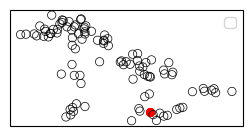

In [26]:
fig = deepsensor.plot.placements(placement_tasks[0], X_new_df, data_processor,
                                 crs=ccrs.PlateCarree())

Although this plot isn't the easiest to read, it seems that the GreedyAlgorithm is recommending that we focus on Western Lake Erie, which is good to see, as this is exactly where the current network does have a high density of instruments. So to first order, the existing observing network isn't too bad. 

# Conclusion

In this notebook, we implemented active learning to improve model training by focusing on the most informative data points. We:
1. Loaded and preprocessed several datasets for training.
2. Used the **GreedyAlgorithm** to select uncertain data points for model training.
3. Visualized the placement of these points on the map.

Active learning helps ensure that the model is trained on the most challenging examples, which can improve its performance.


# Reproducibility

Below we list some aspects of the computing environment for better reproduciblity. 

In [5]:
import sys
print("Python Executable:", sys.executable)
print("Python Version:", sys.version)
!pip freeze > requirements.txt
print("requirements.txt generated!")

Python Executable: /home/dannes/ds_env_gpu/bin/python
Python Version: 3.10.9 (main, Mar  1 2023, 18:23:06) [GCC 11.2.0]
requirements.txt generated!
